# Analysis of DNA-MERFISH for CTP11

by Pu Zheng

2022.02.15

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_0\20220215-P_brain_CTP11-1000_CTP12_from0208

This data is DNA of uncleared MERFISH RNA:
    \\10.245.74.158\Chromatin_NAS_0\20220208-P_brain_M1_nonclear


In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd
from tqdm import tqdm

36656


In [2]:
fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_1\20220307-P_brain_CTP11_from_0303',
             'save_folder':r'\\mendel\Mendel_SSD4\Pu_Temp\20220307-P_brain_CTP11_from_0303',
             'experiment_type': 'DNA',
             'num_threads': 44,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647','561'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'corr_bleed':True,
                     'min_num_seeds':10,
                     'max_num_seeds': 20000,
                     'spot_seeding_th': 1000,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':False,
                 }, 
             }

## 1.1 define required floders

In [6]:
save_folder = fov_param['save_folder']

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")


50 fovs detected
Use segmentation_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220307-P_brain_CTP11_from_0303\Segmentation
Use cand_spot_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220307-P_brain_CTP11_from_0303\CandSpots
Use decoder_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220307-P_brain_CTP11_from_0303\Decoder


In [7]:
save_fov_ids = save_fov_ids[:10]
save_filenames = save_filenames[:10]

## 1.2 get dict for cell uid

In [9]:
%%time
_total_seg_save_file = os.path.join(segmentation_folder, 'full_segmentation.hdf5')

fovcell_2_uid = {}
with h5py.File(_total_seg_save_file, 'r') as _f:
    for _fov_id in _f.keys():
        _fov_group = _f[_fov_id]
        _uid_group = _fov_group['cell_2_uid']
        for _cell_id in _uid_group.keys():
            fovcell_2_uid[(_fov_id, _cell_id)] = _uid_group[_cell_id][:][0]
print(len(fovcell_2_uid))

1532
Wall time: 501 ms


## 1.3 get cell_uid to cell-class

In [10]:
%%time
import scanpy as sc

# load cell type info
merfish_cluster_file = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\20220303-P_brain_M1_nonclear_adaptors\PostAnalysis\filtered_cluster_data_labeled.h5ad'

merfish_df = sc.read_h5ad(merfish_cluster_file)

uid_2_class = {_uid:_class for _uid, _class in zip(merfish_df.obs.index, merfish_df.obs['subclass_manual_label'])}

OSError: Unable to open file (unable to open file: name = '\\mendel\Mendel_SSD3\MERFISH_Analysis\20220303-P_brain_M1_nonclear_adaptors\PostAnalysis\filtered_cluster_data_labeled.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# 2. export spot_groups

In [11]:
%%time
# loop through fovs
load_key = 'spot_groups'
# save into file
export_decode_folder = r'E:\Users\puzheng\Dropbox (Harvard University)\2022_Brain_DnaMerfish\Data'

overwrite_export = False

SpotGroupDfs = []
for _fov_id in save_fov_ids:
    _export_filename = os.path.join(export_decode_folder, f"DecodeGroup_Fov-{_fov_id}.hdf5")
    print(_export_filename)
    if os.path.exists(_export_filename) and not overwrite_export:
        continue
    _cell_ids = [_g[1] for _g in fovcell_2_uid.keys() if str(_g[0])==str(_fov_id)]
    for _cell_id in tqdm(_cell_ids):
        _decoder_filename = os.path.join(decoder_folder, 
                                         f"Fov-{_fov_id}_Cell-{_cell_id}_Decoder.hdf5")
        if os.path.isfile(_decoder_filename):
            #print(_fov_id, _cell_id)
            _df = pd.read_hdf(_decoder_filename, load_key)
            _uid = fovcell_2_uid[(str(_fov_id), _cell_id)]
            _df['uid'] = _uid
            # merfish class
            _class = merfish_df.obs.loc[merfish_df.obs.index==_uid,'subclass_manual_label'].values
            if len(_class) == 0:
                _df['manual_class'] = None
            else:
                _df['manual_class'] = _class[0]
                
            SpotGroupDfs.append(_df)
            # save this df
            _df.to_hdf(_export_filename, f"Cell-{_cell_id}", complevel=1, complib='blosc:zstd')
    

E:\Users\puzheng\Dropbox (Harvard University)\2022_Brain_DnaMerfish\Data\DecodeGroup_Fov-0.hdf5
E:\Users\puzheng\Dropbox (Harvard University)\2022_Brain_DnaMerfish\Data\DecodeGroup_Fov-1.hdf5
E:\Users\puzheng\Dropbox (Harvard University)\2022_Brain_DnaMerfish\Data\DecodeGroup_Fov-2.hdf5
E:\Users\puzheng\Dropbox (Harvard University)\2022_Brain_DnaMerfish\Data\DecodeGroup_Fov-3.hdf5
E:\Users\puzheng\Dropbox (Harvard University)\2022_Brain_DnaMerfish\Data\DecodeGroup_Fov-4.hdf5
E:\Users\puzheng\Dropbox (Harvard University)\2022_Brain_DnaMerfish\Data\DecodeGroup_Fov-5.hdf5
E:\Users\puzheng\Dropbox (Harvard University)\2022_Brain_DnaMerfish\Data\DecodeGroup_Fov-6.hdf5
E:\Users\puzheng\Dropbox (Harvard University)\2022_Brain_DnaMerfish\Data\DecodeGroup_Fov-7.hdf5
E:\Users\puzheng\Dropbox (Harvard University)\2022_Brain_DnaMerfish\Data\DecodeGroup_Fov-8.hdf5
E:\Users\puzheng\Dropbox (Harvard University)\2022_Brain_DnaMerfish\Data\DecodeGroup_Fov-9.hdf5
Wall time: 198 ms


In [33]:
# test loading
_export_filename = os.path.join(export_decode_folder, f"DecodeGroup_Fov-{save_fov_ids[0]}.hdf5")
pd.read_hdf(_export_filename, 'Cell-1')

# 3. load chr_2_zxys_list

## 3.1 load codebook

In [12]:
import pandas as pd
codebook_filename = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv'
#
codebook_df = pd.read_csv(codebook_filename, header=0)
codebook_df

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_824,NDB_712,NDB_818,NDB_940,NDB_872,NDB_934,NDB_926,NDB_910,chr,chr_order
0,1:3740000-3760000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1:6240000-6260000,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1:8740000-8760000,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
3,1:11240000-11260000,4,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
4,1:13740000-13760000,5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,X:161240000-161260000,1057,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,X,52
984,X:163740000-163760000,1058,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,X,53
985,X:166240000-166260000,1059,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,X,54
986,X:168740000-168760000,1060,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,55


## 3.2 load chr_2_zxys_list

In [13]:
#decoder_folder = os.path.join(save_folder, 'Decoder')
decoder_filenames = [os.path.join(decoder_folder, _fl) for _fl in os.listdir(decoder_folder) 
                     if '_Decoder.hdf5' in _fl]
print(decoder_folder, len(decoder_filenames))

\\mendel\Mendel_SSD4\Pu_Temp\20220307-P_brain_CTP11_from_0303\Decoder 1283


In [14]:
import re
import multiprocessing as mp
from ImageAnalysis3.classes.decode import load_hdf5_dict
from ImageAnalysis3.classes.decode import DNA_Merfish_Decoder

In [15]:
%%time
overwrite_coodinates=False

coord_savefile = os.path.join(decoder_folder, f'all_coordinates_Fov-{min(save_fov_ids)}-{max(save_fov_ids)}.npy')
uid_savefile = os.path.join(decoder_folder, f'all_uids_Fov-{min(save_fov_ids)}-{max(save_fov_ids)}.npy')

if os.path.exists(coord_savefile) and os.path.exists(uid_savefile) and not overwrite_coodinates:
    print("Directly load all all_zxys_list")
    all_zxys_list = np.load(coord_savefile)
    uid_list = np.load(uid_savefile)
else:
    print("Batch load all_zxys_list")
    # Batch loading
    load_args = [(_fl, 'chr_2_zxys_list') for _fl in decoder_filenames]
    print(len(load_args))
    with mp.Pool(44) as load_pool:
        all_chr_2_zxys_list = load_pool.starmap(load_hdf5_dict, 
                                                load_args, 
                                                chunksize=1)
        load_pool.close()
        load_pool.join()
        load_pool.terminate()
    # Batch summarize
    kept_decoder_filenames = [_fl for _fl,_item in zip(decoder_filenames, all_chr_2_zxys_list) if _item is not None]
    all_chr_2_zxys_list = [_item for _item in all_chr_2_zxys_list if _item is not None]
    print(len(kept_decoder_filenames), len(all_chr_2_zxys_list))

    summary_args = [(_item, codebook_df) for _item in all_chr_2_zxys_list ]
    print(len(summary_args))
    with mp.Pool(44) as summary_pool: 
        all_zxys_list = summary_pool.starmap(DNA_Merfish_Decoder.summarize_zxys_by_regions, 
                                             summary_args, chunksize=1)
        summary_pool.close()
        summary_pool.join()
        summary_pool.terminate()
    # UIDs    
    uid_list = [fovcell_2_uid[
        re.findall(r'Fov-([0-9]+)_Cell-([0-9]+)_Decoder.hdf5', os.path.basename(_fl))[0]
               ] for _fl in kept_decoder_filenames]
    # SAVE
    print(f"saving coordinates into file: {coord_savefile}.")
    np.save(coord_savefile.split('.npy')[0], all_zxys_list)
    # save UID
    np.save(uid_savefile.split('.npy')[0], uid_list)

Batch load all_zxys_list
1283
1283 1283
1283
saving coordinates into file: \\mendel\Mendel_SSD4\Pu_Temp\20220307-P_brain_CTP11_from_0303\Decoder\all_coordinates_Fov-0-9.npy.
Wall time: 1min 53s


# 4. Summarize

In [16]:
save_figure = True

decode_figure_folder = os.path.join(decoder_folder, 'Figures')
if not os.path.exists(decode_figure_folder):
    os.makedirs(decode_figure_folder)
    print(f"Creating decode_figure_folder: {decode_figure_folder}")
else:
    print(f"Use decode_figure_folder: {decode_figure_folder}")

Creating decode_figure_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220307-P_brain_CTP11_from_0303\Decoder\Figures


<IPython.core.display.Javascript object>


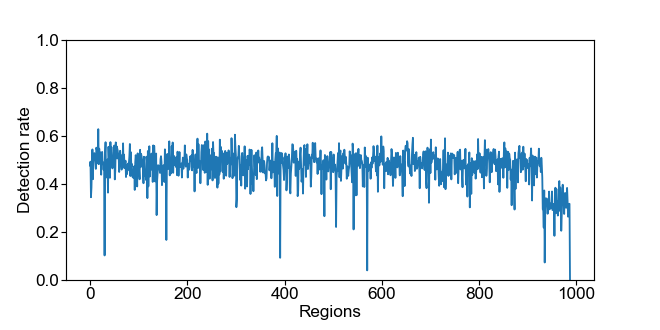

\\mendel\Mendel_SSD4\Pu_Temp\20220307-P_brain_CTP11_from_0303\Decoder\Figures\loss_rates.png


In [17]:
all_zxys = np.concatenate(all_zxys_list)
loss_rates = np.mean(np.isnan(all_zxys).any(2), axis=0)

fig, ax = plt.subplots(figsize=(4,2),dpi=150)
_l = ax.plot(1-loss_rates, linewidth=0.8)
ax.set_ylim([0,1])
ax.set_xlabel('Regions', labelpad=1, fontsize=7.5)
ax.set_ylabel('Detection rate', labelpad=1, fontsize=7.5)

# border
[i[1].set_linewidth(0.5) for i in ax.spines.items()]
# ticks
ax.tick_params('both', labelsize=7.5, 
               width=0.5, length=2,
               pad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1,)
if save_figure:
    loss_rate_fig_fl = os.path.join(decode_figure_folder, 'loss_rates.png')
    print(loss_rate_fig_fl)
    fig.savefig(loss_rate_fig_fl, transparent=True)
fig.show()

## classes

In [20]:
class_labels = []
for _uid in uid_list:
    if _uid in uid_2_class:
        class_labels.append(uid_2_class[_uid])
    else:
        class_labels.append('None')

In [21]:
_classes, _class_counts = np.unique(class_labels, return_counts=True)

In [22]:
_classes, _class_counts

(array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
        'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Micro', 'None', 'OPC', 'Oligo',
        'Other', 'Peri', 'Pvalb', 'Sncg', 'Sst', 'VLMC-SMC', 'Vip'],
       dtype='<U8'),
 array([ 999,  446, 1083,  786,  458,  898,  297, 1496,  656,  178,   87,
         180, 8329,  394, 1054,   82,  233,  391,  132,  244,  156,  139],
       dtype=int64))

In [26]:
all_zxys = np.concatenate(all_zxys_list) * 1000
#all_zxys = all_zxys.astype(np.int32)

In [31]:
_zxys = np.ma.array(all_zxys[0]*1000, mask=np.isnan(all_zxys[0]), dtype=np.int32)

In [34]:
from scipy.spatial.distance import pdist, squareform

In [37]:
(squareform(pdist(_zxys)))

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.92174806e+09, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.92174806e+09, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.92174806e+09, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.92174806e+09, 3.92174806e+09, 3.92174806e+09, ...,
        0.00000000e+00, 3.92174806e+09, 3.92174806e+09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.92174806e+09, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.92174806e+09, 0.00000000e+00, 0.00000000e+00]])

In [18]:
%%time
reload(ia.figure_tools.distmap)
from ImageAnalysis3.figure_tools.distmap import batch_zxys_2_distmap


# multi-processing
with mp.Pool(44) as distmap_pool:
    all_distmaps = distmap_pool.starmap(
        batch_zxys_2_distmap, 
        [(_zxys,) for _zxys in all_zxys], 
        chunksize=1,
    )
    distmap_pool.close()
    distmap_pool.join()
    distmap_pool.terminate()

Wall time: 1min 30s


In [19]:
%%time
from ImageAnalysis3.classes import postanalysis
median_distmap = postanalysis.parallel_reduce_matrix(all_distmaps, 
                                                     function='nanmedian', 
                                                     axis=0,
                                                     num_threads=44)

Wall time: 2min 41s


# Figures

In [22]:
save_figure = True
#figure_folder = os.path.join(save_folder, 'Figures_final')
figure_folder = os.path.join(decoder_folder, 'Figures_final')
if not os.path.exists(figure_folder):
    print(f"Create figure_folder: {figure_folder}")
    os.makedirs(figure_folder)
else:
    print(f"Use figure_folder: {figure_folder}")

Create figure_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220307-P_brain_CTP11_from_0303\Decoder\Figures_final


# Plot total median distmap

In [20]:
_ordered_chr_names = []
for _chr_name, _chr_reg_id in zip(codebook_df['chr'], codebook_df['chr_order']):
    if _chr_name not in _ordered_chr_names:
        _ordered_chr_names.append(_chr_name)
chr_2_indices = {_chr:np.array(codebook_df.loc[codebook_df['chr']==_chr].index)
                for _chr in np.unique(codebook_df['chr'].values)}

_labels_edges = np.array([0] + [np.max(chr_2_indices[_chr]) for _chr in _ordered_chr_names])

<IPython.core.display.Javascript object>


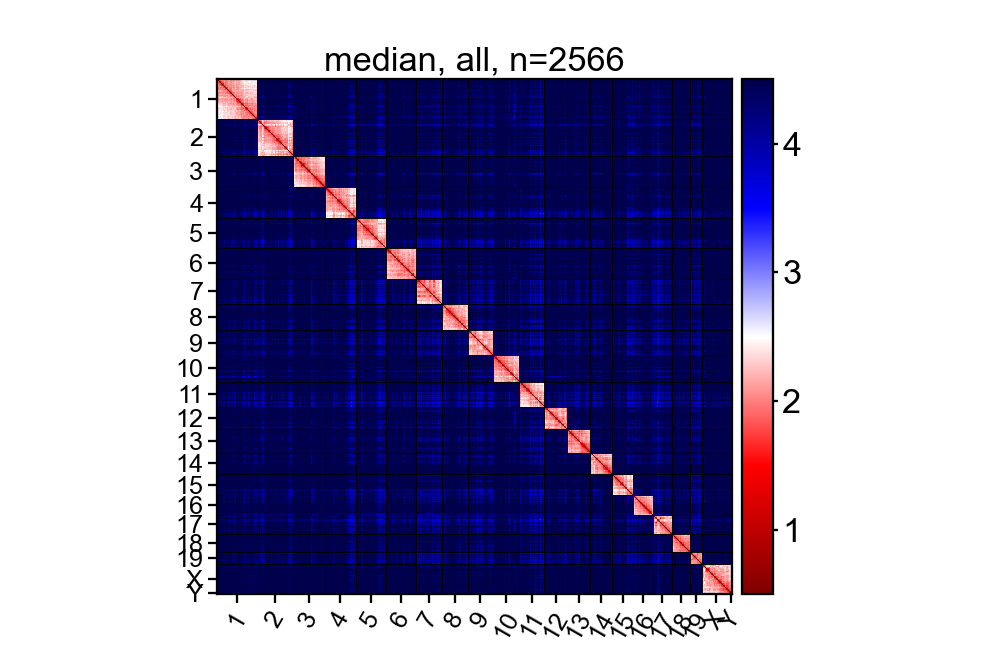

In [24]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(median_distmap, color_limits=[0.5,4.5],
                                          ax=ax,
                                          )
ax.set_title(f'median, all, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_median_distmap.png'), transparent=True)
fig.show()